In [1]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [26]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [920 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main 

In [27]:
RAVDESS = "/content/drive/MyDrive/SER/SER_Daata/RAVDESS/"
TESS = "/content/drive/MyDrive/SER/SER_Daata/TESS/"
Savee = "/content/drive/MyDrive/SER/SER_Daata/Savee/"
Crema ="/content/drive/MyDrive/SER/SER_Daata/CREMAD/AudioWAV/"

In [28]:
#RAVDESS
ravdess_directory_list = os.listdir(RAVDESS)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(RAVDESS + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(RAVDESS + dir + '/' + file)  
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])        
path_df = pd.DataFrame(file_path, columns=['Path'])
RAVDESS_df = pd.concat([emotion_df, path_df], axis=1)
RAVDESS_df.Emotions.replace({1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust', 8:'Surprise'}, inplace=True)


In [29]:
RAVDESS_df.head()

,Emotions,Path
0,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...
1,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...
2,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...
3,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...
4,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...


In [30]:
#TESS
dir_list = os.listdir(TESS)
dir_list.sort()
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('Angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('Disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('Fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('Happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('Neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('Surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('Sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)
TESS_df = pd.DataFrame(emotion, columns = ['Emotions'])
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['Path'])],axis=1)
TESS_df.Emotions.value_counts()        

Fear        400
Surprise    400
Sad         400
Angry       400
Disgust     400
Happy       400
Neutral     400
Name: Emotions, dtype: int64

In [31]:
TESS_df.head() 

,Emotions,Path
0,Fear,/content/drive/MyDrive/SER/SER_Daata/TESS/OAF_...
1,Fear,/content/drive/MyDrive/SER/SER_Daata/TESS/OAF_...
2,Fear,/content/drive/MyDrive/SER/SER_Daata/TESS/OAF_...
3,Fear,/content/drive/MyDrive/SER/SER_Daata/TESS/OAF_...
4,Fear,/content/drive/MyDrive/SER/SER_Daata/TESS/OAF_...


In [32]:
#SAVEE
savee_directory_list = os.listdir(Savee)
file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('Angry')
    elif ele=='d':
        file_emotion.append('Disgust')
    elif ele=='f':
        file_emotion.append('Fear')
    elif ele=='h':
        file_emotion.append('Happy')
    elif ele=='n':
        file_emotion.append('Neutral')
    elif ele=='sa':
        file_emotion.append('Sad')
    else:
        file_emotion.append('Surprise')
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
       

In [33]:
Savee_df.head() 

,Emotions,Path
0,Angry,/content/drive/MyDrive/SER/SER_Daata/Savee/DC_...
1,Angry,/content/drive/MyDrive/SER/SER_Daata/Savee/DC_...
2,Angry,/content/drive/MyDrive/SER/SER_Daata/Savee/DC_...
3,Angry,/content/drive/MyDrive/SER/SER_Daata/Savee/DC_...
4,Angry,/content/drive/MyDrive/SER/SER_Daata/Savee/DC_...


In [34]:
#crema
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(Crema + file)
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('Sad')
    elif part[2] == 'ANG':
        file_emotion.append('Angry')
    elif part[2] == 'DIS':
        file_emotion.append('Disgust')
    elif part[2] == 'FEA':
        file_emotion.append('Fear')
    elif part[2] == 'HAP':
        file_emotion.append('Happy')
    elif part[2] == 'NEU':
        file_emotion.append('Neutral')
    else:
        file_emotion.append('Unknown')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()      

,Emotions,Path
0,Disgust,/content/drive/MyDrive/SER/SER_Daata/CREMAD/Au...
1,Disgust,/content/drive/MyDrive/SER/SER_Daata/CREMAD/Au...
2,Happy,/content/drive/MyDrive/SER/SER_Daata/CREMAD/Au...
3,Sad,/content/drive/MyDrive/SER/SER_Daata/CREMAD/Au...
4,Neutral,/content/drive/MyDrive/SER/SER_Daata/CREMAD/Au...


In [35]:
data_path = pd.concat([RAVDESS_df, Crema_df, TESS_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...
1,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...
2,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...
3,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...
4,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...


In [36]:
import collections
counter = collections.Counter(data_path.Emotions)
counter

Counter({'Calm': 192,
         'Neutral': 1082,
         'Angry': 1199,
         'Happy': 1199,
         'Sad': 1198,
         'Disgust': 1199,
         'Surprise': 665,
         'Fear': 1199})

<BarContainer object of 7933 artists>

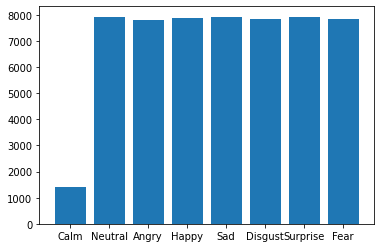

In [37]:
xn = range(len(data_path.Emotions))
plt.bar(data_path.Emotions,xn )


In [38]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

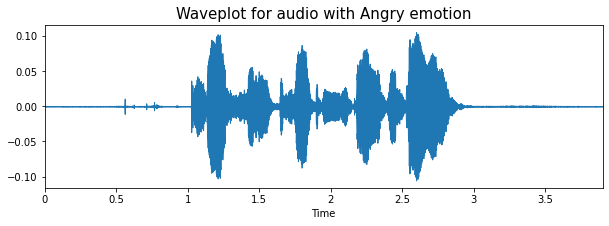

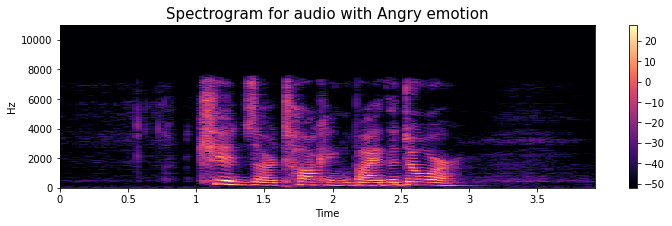

In [108]:
emotion='Angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

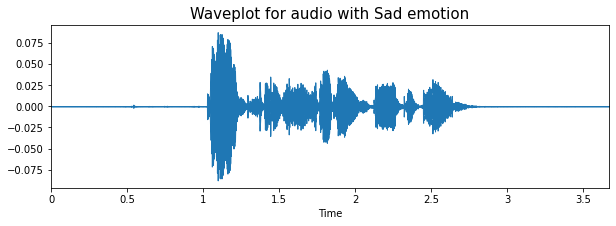

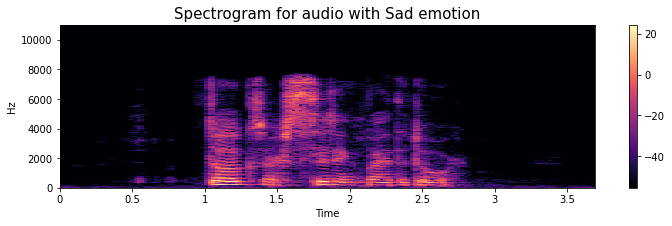

In [110]:
emotion='Sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

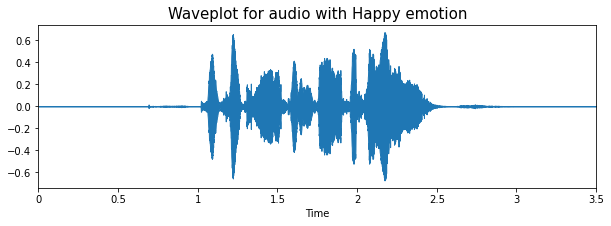

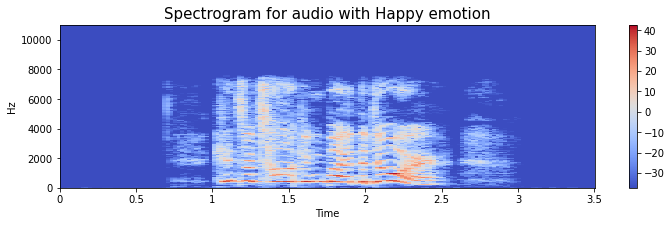

In [112]:
emotion='Happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [113]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# example
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

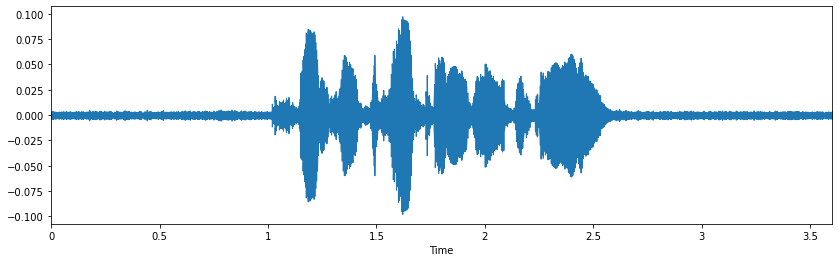

In [114]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

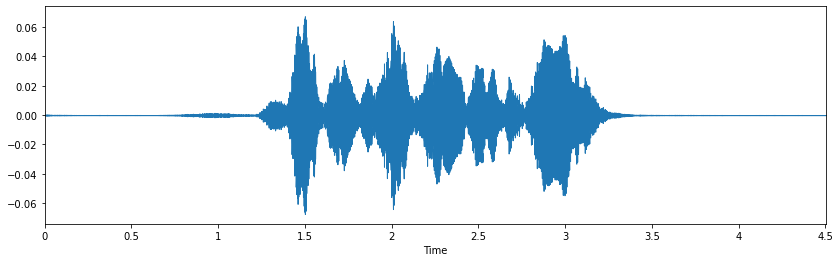

In [115]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

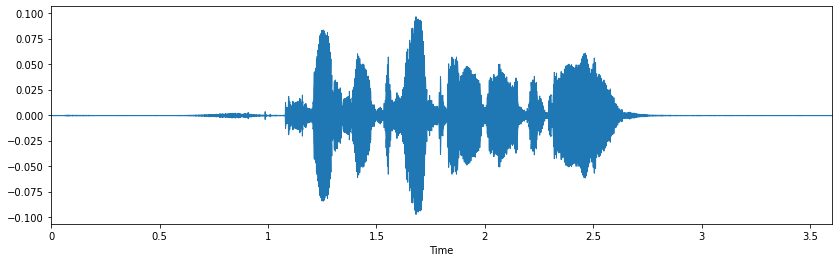

In [116]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

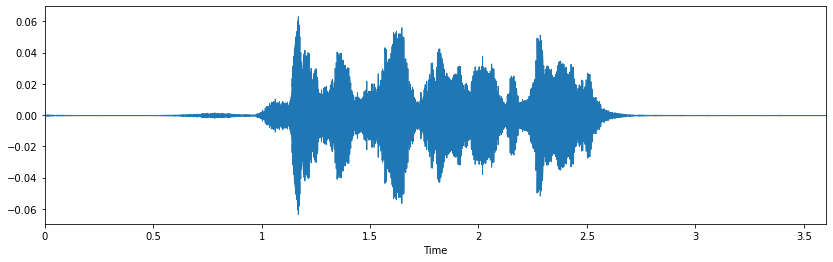

In [117]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [118]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) 

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    res1 = extract_features(data)
    result = np.array(res1)
    
    # with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 
    
    # with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) 
    
    return result    

In [119]:
data_path['Index'] = data_path.index
data_path.head()

,Emotions,Path,Index
0,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...,0
1,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...,1
2,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...,2
3,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...,3
4,Calm,/content/drive/MyDrive/SER/SER_Daata/RAVDESS/A...,4


In [144]:
X, Y = [], []
for index, path, emotion in zip(data_path.Index, data_path.Path, data_path.Emotions):
    feature = get_features(path)
    if (index % 100 == 0):
            print("Import Data: RUNNING ... {} files".format(index))
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

Import Data: RUNNING ... 0 files
Import Data: RUNNING ... 100 files
Import Data: RUNNING ... 200 files
Import Data: RUNNING ... 300 files
Import Data: RUNNING ... 400 files
Import Data: RUNNING ... 500 files
Import Data: RUNNING ... 600 files
Import Data: RUNNING ... 700 files
Import Data: RUNNING ... 800 files
Import Data: RUNNING ... 900 files
Import Data: RUNNING ... 1000 files
Import Data: RUNNING ... 1100 files
Import Data: RUNNING ... 1200 files
Import Data: RUNNING ... 1300 files
Import Data: RUNNING ... 1400 files
Import Data: RUNNING ... 0 files
Import Data: RUNNING ... 100 files
Import Data: RUNNING ... 200 files
Import Data: RUNNING ... 300 files
Import Data: RUNNING ... 400 files
Import Data: RUNNING ... 500 files
Import Data: RUNNING ... 600 files
Import Data: RUNNING ... 700 files
Import Data: RUNNING ... 800 files
Import Data: RUNNING ... 900 files
Import Data: RUNNING ... 1000 files
Import Data: RUNNING ... 1100 files
Import Data: RUNNING ... 1200 files
Import Data: RUN

In [72]:
Features = pd.read_csv("/content/drive/MyDrive/SER/SER_Daata/features.csv")
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.113855,0.490566,0.385602,0.347967,0.404583,0.399601,0.416247,0.489351,0.493810,0.560716,...,1.137087e-12,1.038507e-12,9.635413e-13,9.042003e-13,8.573312e-13,8.213548e-13,7.939398e-13,7.752360e-13,7.634490e-13,Calm
1,0.247925,0.613437,0.550577,0.535178,0.594789,0.594670,0.531589,0.534974,0.525286,0.600223,...,2.995092e-04,3.068409e-04,2.954923e-04,2.976553e-04,3.149054e-04,2.829368e-04,2.795701e-04,2.802430e-04,3.000537e-04,Calm
2,0.123821,0.628385,0.483533,0.377000,0.349225,0.426523,0.408662,0.415607,0.507843,0.493631,...,6.864734e-13,6.613900e-13,7.989993e-13,6.158552e-13,6.296408e-13,7.048127e-13,7.601136e-13,7.970585e-13,7.725193e-13,Calm
3,0.126741,0.518887,0.522334,0.500355,0.462463,0.469554,0.574812,0.644812,0.710585,0.678665,...,2.625194e-12,2.401916e-12,2.216103e-12,2.061352e-12,1.935336e-12,1.836937e-12,1.761397e-12,1.708924e-12,1.676403e-12,Calm
4,0.268971,0.667440,0.665820,0.663013,0.634271,0.629466,0.626405,0.667601,0.726781,0.696014,...,3.446236e-04,3.351294e-04,3.598481e-04,3.626727e-04,3.610991e-04,3.763245e-04,3.754325e-04,3.619234e-04,3.574872e-04,Calm


In [73]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [74]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [75]:
if X.shape[0] != Y.shape[0]:
  print("X and Y rows are mismatched, check dataset again")
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17849, 162), (17849, 8), (5950, 162), (5950, 8))

In [76]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17849, 162), (17849, 8), (5950, 162), (5950, 8))

In [77]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17849, 162, 1), (17849, 8), (5950, 162, 1), (5950, 8))

In [78]:
input_x = tf.keras.layers.Input(shape= (x_train.shape[1],1))


In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [80]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 81, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 41, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 21, 128)         

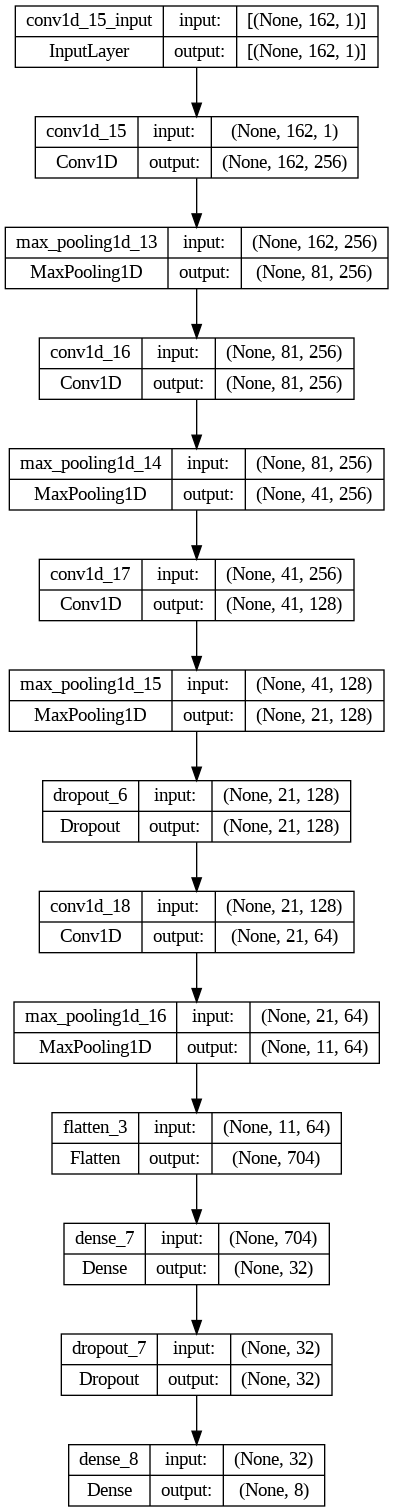

In [81]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='modelcnn-b.png')

In [82]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
279/279 [==============================] - 187s 664ms/step - loss: 1.7576 - accuracy: 0.2999 - val_loss: 1.5031 - val_accuracy: 0.4208 - lr: 0.0010
Epoch 2/50
279/279 [==============================] - 147s 527ms/step - loss: 1.4557 - accuracy: 0.4282 - val_loss: 1.3014 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 3/50
279/279 [==============================] - 144s 516ms/step - loss: 1.3237 - accuracy: 0.4820 - val_loss: 1.2299 - val_accuracy: 0.5264 - lr: 0.0010
Epoch 4/50
279/279 [==============================] - 156s 559ms/step - loss: 1.2162 - accuracy: 0.5222 - val_loss: 1.1193 - val_accuracy: 0.5618 - lr: 0.0010
Epoch 5/50
279/279 [==============================] - 144s 515ms/step - loss: 1.1465 - accuracy: 0.5504 - val_loss: 1.0789 - val_accuracy: 0.5728 - lr: 0.0010
Epoch 6/50
279/279 [==============================] - 139s 499ms/step - loss: 1.1016 - accuracy: 0.5651 - val_loss: 1.0781 - val_accuracy: 0.5766 - lr: 0.0010
Epoch 7/50
279/279 [==========================

In [83]:
from keras.models import load_model
model.save("CNNModel.h5")

In [84]:
import keras.backend as K
import tensorflow as tf
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

186/186 [==============================] - 10s 54ms/step - loss: 1.0355 - accuracy: 0.6982
Accuracy of our model on test data :  69.81512308120728 %


ValueError: ignored

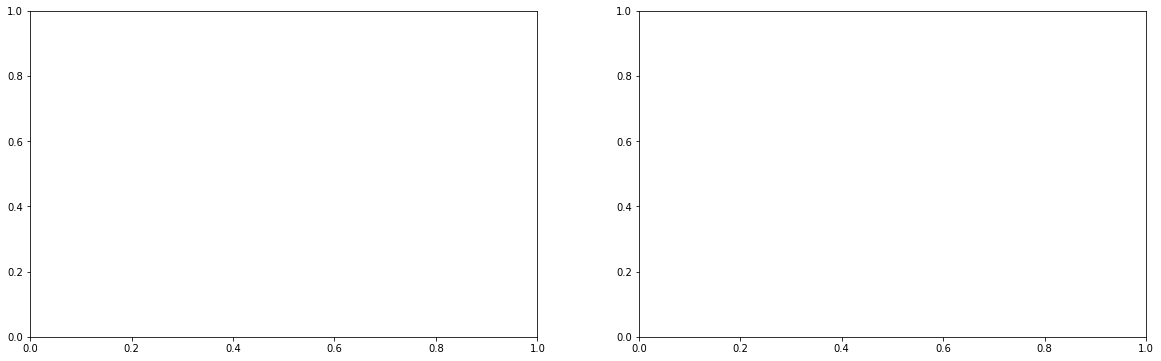

In [85]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

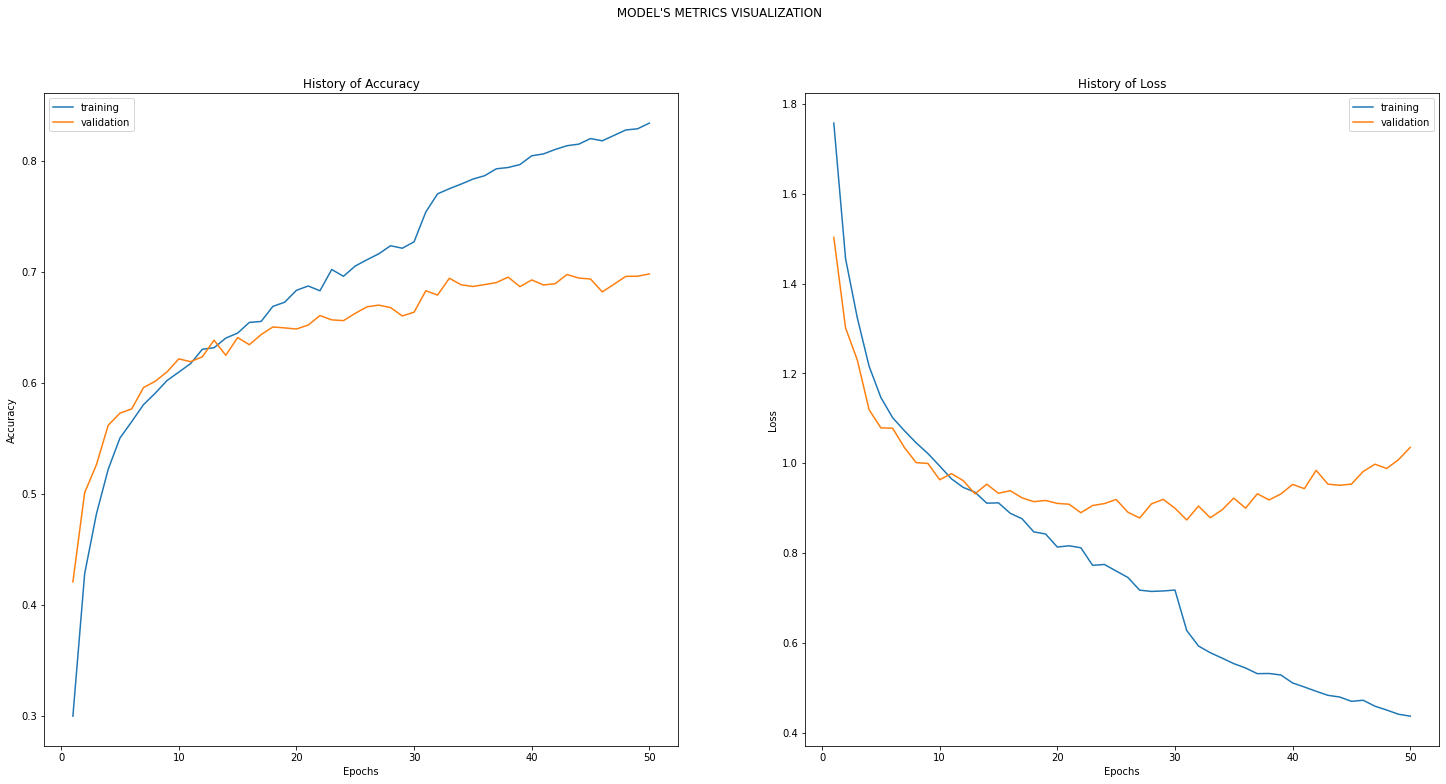

In [86]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (25,12))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    

    plt.show()
  

Train_Val_Plot(history.history['accuracy'],
               history.history['val_accuracy'],
               history.history['loss'],
               history.history['val_loss']
              )    

In [87]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

# Check for random predictions
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head()

186/186 [==============================] - 9s 47ms/step


,Predicted Labels,Actual Labels
0,Fear,Fear
1,Angry,Angry
2,Happy,Happy
3,Sad,Sad
4,Calm,Calm


<ipython-input-88-262348620436>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


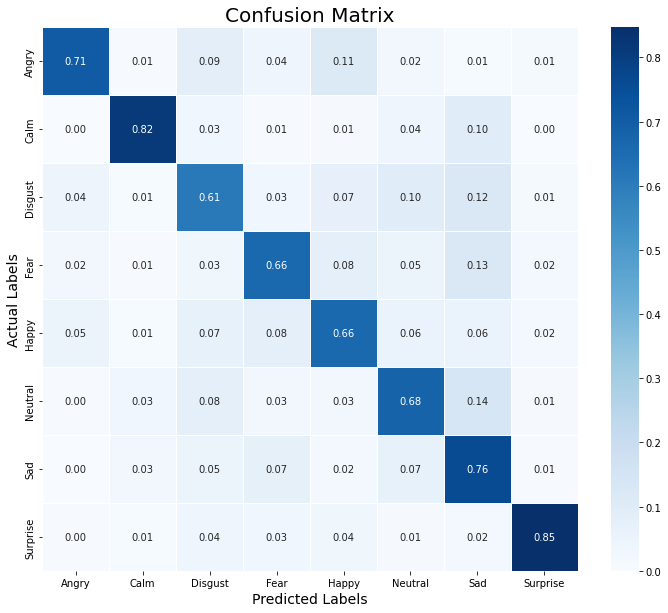

              precision    recall  f1-score   support

       Angry       0.86      0.71      0.77       936
        Calm       0.63      0.82      0.71       164
     Disgust       0.64      0.61      0.63       889
        Fear       0.70      0.66      0.68       852
       Happy       0.67      0.66      0.67       921
     Neutral       0.66      0.68      0.67       795
         Sad       0.62      0.76      0.68       896
    Surprise       0.86      0.85      0.85       497

    accuracy                           0.70      5950
   macro avg       0.71      0.72      0.71      5950
weighted avg       0.71      0.70      0.70      5950



In [88]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))